## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that to get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.
<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, we read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
user_count = df.user_id.nunique()
user_count

290584

d. The proportion of users converted.

In [5]:
converted_p = df[df['converted'] == 1]['user_id'].nunique()/user_count
converted_p

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
count_mismatch = len(df[df['landing_page'] == 'new_page'][df['group'] != 'treatment']) + len(df[df['landing_page'] != 'new_page'][df['group'] == 'treatment'])
count_mismatch

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


3893

f. Do any of the rows have missing values?

In [7]:
df.info() #checking to see that all rows have the same number of entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` There are some rows where the control group did not land on the old page or the treatment group was not given the new page as their landing page. We have to remove these outliers below. I will remove these using a filter and save the new set into df2.  

In [8]:
df2 = df[((df.group == 'control') & (df.landing_page == 'old_page')) | ((df.group == 'treatment') & (df.landing_page == 'new_page'))]
df2.shape #looks like there were approximately 4000 rows dropped

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Now we should look at some important factors present in df2

a. How many unique **user_id**s are in **df2**? We need to know this because we do not want to give more weight to a response from the same user.

In [10]:
df2.user_id.nunique()

290584

b. We should check to see if any of the user_id values are duplicated. Uh oh looks like we have one.

In [11]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Now we can remove one the duplicated user ids using the index. Then check to see if there is only one record for the user id after dropping.

In [13]:
df2 = df2.drop([1899]) #dropping one of the rows with the duplicate id
df2[df2['user_id'] == 773192] #check to see if the row is dropped

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Now we can look at some of the probabilities associated with df2

a. What is the probability of an individual converting regardless of the page they receive? How many unique user ids were given the new page as their landing page? the old page?

In [14]:
total_converted = len(df2[df2['converted'] ==  1]) / len(df2) #probability of being converted regardless of the received page
new_count = df2[df2['landing_page'] == "new_page"]['user_id'].nunique() #number of users landing on new page
old_count = df2[df2['landing_page'] == "old_page"]['user_id'].nunique() #number of users landing on old page
total_converted, new_count, old_count

(0.11959708724499628, 145310, 145274)

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_converted = len(df2[df2['group'] == 'control'][df2['converted'] ==  1]) / len(df2[df2['group'] == 'control'])
control_converted

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_converted = len(df2[df2['group'] == 'treatment'][df2['converted'] ==  1]) / len(df2[df2['group'] == 'treatment'])
treatment_converted

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
new_page_p = len(df2[df2['landing_page'] ==  'new_page']) / len(df2)
new_page_p

0.5000619442226688

The difference in probability of conversion given that the user was given the new landing page instead of the old page is not very large. This is not enough evidence to say that the new landing page will lead to more conversions. We will likely want to run some more tests to see if this difference is statistically significant.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we will make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null: Pold - Pnew >= 0 , Alternative: Pold - Pnew < 0, alpha = 0.5

`2.` Assumptions: 
Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Now I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

First I will use the cells below to provide the necessary parts of this simulation. <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
new_count

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
old_count

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(new_count, p_new, 10000)/new_count
new_page_converted

array([ 0.12020508,  0.12040465,  0.12037024, ...,  0.11991604,
        0.11842956,  0.11934485])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(old_count, p_old, 10000)/old_count 
old_page_converted

array([ 0.11929182,  0.11837631,  0.11970483, ...,  0.12033124,
        0.11950521,  0.11989069])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diffs = old_page_converted - new_page_converted
diffs.mean()

1.7036479137602174e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(new_count, p_new, 10000)/new_count
    old_page_converted = np.random.binomial(old_count, p_old, 10000)/old_count 
    p_diffs.append(old_page_converted - new_page_converted)
np.mean(p_diffs)

-1.8782540181625574e-07

i. Plot a histogram of the **p_diffs**. 

(array([    8.,    98.,   558.,  1630.,  2798.,  2746.,  1560.,   516.,
           76.,    10.]),
 array([ -4.59417738e-03,  -3.66513978e-03,  -2.73610217e-03,
         -1.80706457e-03,  -8.78026965e-04,   5.10106392e-05,
          9.80048243e-04,   1.90908585e-03,   2.83812345e-03,
          3.76716106e-03,   4.69619866e-03]),
 <a list of 10 Patch objects>)

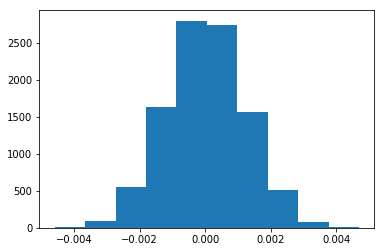

In [26]:
p_difference = np.random.normal(0, np.std(p_diffs), 10000)
plt.hist(p_difference)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(p_difference > diffs).sum()/len(p_difference)

0.5

k. In words, I will explain what was just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This shows that our simulated scenario is now very close to what was observed in the entire ab_data.csv file. This follows the law of large numbers stating that with larger sample sizes the sample statistic gets closer to the population parameter. These findings also support the Central limit theorem that states with large enough sample sizes the shape of a distribution becomes more normal. This value shows that the difference between the proportion of users that are "converted" given that they were shown the old page vs. the new landing pages follows a normal distribution centered at zero. This value is called a statistic and it is used to estimate a population parameter. With such a large p-value we cannot reject the null hypothesis and must state that the difference in proportion of converted users based on landing page does not have a significant effect on conversion rate.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = len(df2[df2['landing_page'] == 'old_page'][df2['converted'] == 1])
convert_new = len(df2[df2['landing_page'] == 'new_page'][df2['converted'] == 1])
n_old = old_count
n_new = new_count
convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


(17489, 17264, 145274, 145310)

m. Now we will use `stats.proportions_ztest` to compute the test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest(count=convert_new, nobs=n_new, value=0, alternative='smaller')
print(pval, stat)

1.0 139.970159328


**The z-score and p-value show us that the difference in conversion rate for the new and old pages are not statistically significant and accept the null hypothesis and say that the difference in conversion rate based on landing page is not statistically advantaged by which page the user lands on. This agrees with what we saw previously.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will show that the result I achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since the response variable is categorical and not quantitative we will use logistic regression

b. Using **statsmodels** I will attempt to fit the regression model I specified in part A to see if there is a significant difference in conversion based on which page a customer receives. First, I will create a column in df2 for the intercept, dummy variables for which page each user received, and a column named "ab_page" where 1 signifies a user being a part the treatment group and 0 for the control group.

In [30]:
df2[['control', 'ab_page']] = pd.get_dummies(df2['group']) #getting dummies based on group and saving one as ab_page
df2['intercept'] = 1 #defining an intercept column
df2 = df2.drop('control', axis=1) #dropping control column that will not be used.
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Now using **statsmodels** we will fit a logistic regression to predict the number of converted users based the landing page as well what group they were a part of.

In [31]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of the result will show us how each of the variables can be used to predict conversion rate if all other variables are held constant, as well as a p-value to show if these variables have a significant effect on conversion rate. New page is used as the baseline.

In [32]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        17:29:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Now we look at the p-value associated with **ab_page**. Why does it differ from the value you found in **Part II**?<br><br>

**New we see a large p-value for ab_page(0.19) that would cause the null hypothesis to be accepted under any normal acceptable alpha value. This is because our previous methods approached difference in conversion rate as a quantitative value while this model uses it as a categorical conversion with ab_page not having a statistically significant effect on conversion according to this model. In terms of our earlier stated null hypothesis we would accept the null and say the difference in conversion rate is not significant based upon landing page.**

f. Given the conclusions that were just discussed, should we continue exploring other variables in this data set?  Are there any disadvantages to adding additional terms into your regression model?

**Given what we just found we might consider looking at other factors to see if they have significant effect on a user converting. This can be a good approach but we should be careful to not look at too many factors simultaneously, the results can become difficult to explain and confusing to an audience. Also, these results can become too convoluded and not reflect true results in certain scenarios.**

g. Now we will add in a new set of data for the same users that shows what country they live in. First we read in this set and then join the two data sets on user_id. Then, we get dummy variables for the country the user lives in to be used in our logistic regression. Then we will fit these new variables to a logistic regression model to see if there is a significant effect on a user converting based upon where they live using the US as the baseline.

Summary information:
According to our summary we can use our p-values to see that country did not have a significant effect on conversion. The p-value for the UK and Canada are well above any acceptable threshold to reject a null hypothesis that states that country does not have a significant effect on conversion.

In [33]:
country_df = pd.read_csv('countries.csv') #reading in new data

df_with_country = df2.set_index('user_id').join(country_df.set_index('user_id')) #joining two dfs setting the index as the user_id and joining on that column
df_with_country[['CA', 'UK', 'US']] = pd.get_dummies(df_with_country['country']) #getting dummy columns for country column to fit regression.

logit_mod2 = sm.Logit(df_with_country['converted'], df_with_country[['intercept', 'UK', 'CA']])
results_country = logit_mod2.fit()
results_country.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:               1.521e-05
Time:                        17:29:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

h. Now let's try a model looking at multiple factors simultaneously. For this one we will look at country as well as landing page.
Including these new variables might give us something to focus on when we look to explain what can have the most effect on converting to the new page.

Summary information: </n>
Our summary shows similar results to what we found previously. None of the included factors seem to have a statistically significant effect on conversion of a user. All of the associated p-values are too large to be within any normal acceptable range to reject a null hypothesis of any of these individual factors effecting conversion.

In [34]:
logit_mod = sm.Logit(df_with_country['converted'], df_with_country[['intercept', 'ab_page', 'UK', 'CA']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        17:29:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

In [35]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0